In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions as distrib

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline  
%matplotlib notebook
%pylab

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


### Example of a simple 3d plot

In [3]:
# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# # Make data.
# X = np.arange(-5, 5, 0.25)
# Y = np.arange(-5, 5, 0.25)
# X, Y = np.meshgrid(X, Y)
# R = np.sqrt(X**2 + Y**2)
# Z = np.sin(R)

# # Plot the surface.
# surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
#                        linewidth=0, antialiased=False)

# # Customize the z axis.
# ax.set_zlim(-1.01, 1.01)
# ax.zaxis.set_major_locator(LinearLocator(10))
# # A StrMethodFormatter is used automatically
# ax.zaxis.set_major_formatter('{x:.02f}')

# # Add a color bar which maps values to colors.
# fig.colorbar(surf, shrink=0.5, aspect=5)

# plt.show()

### Distribution params

In [4]:
mu0x = 1.0
mu0y = 1.0
sigma0x = 0.5
sigma0y = 0.5
mu0 = [mu0x, mu0y]
sigma0 = [sigma0x, sigma0y]

mu1x = 2.0
mu1y = 4.0
sigma1x = 2.0
sigma1y = 1.0
mu1 = [mu1x, mu1y]
sigma1 = [sigma1x, sigma1y]

### Plot distributions

In [5]:
def plot_distribution(mu, sigma, pos):
    rv = stats.multivariate_normal(mu, sigma)
    return rv.pdf(pos)
    
def plot_two_distributions(mu0, sigma0, mu1, sigma1):
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    
    X = np.arange(-3, 7, 0.25)
    Y = np.arange(-3, 7, 0.25)
    X, Y = np.meshgrid(X, Y)
    pos = np.dstack((X, Y))
    
    Z = plot_distribution(mu0, sigma0, pos)
    Z = Z + plot_distribution(mu1, sigma1, pos)
    
    # Plot the surface.
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    
    # Customize the z axis.
    ax.set_zlim(0, 1)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter('{x:.01f}')
    
    fig.colorbar(surf, shrink=0.5, aspect=5)
    
    plt.show()

In [6]:
plot_two_distributions(mu0, sigma0, mu1, sigma1)

<IPython.core.display.Javascript object>

### Torch distribution & sampling fun

In [7]:
d0 = distrib.Normal(torch.tensor(mu0), torch.tensor(sigma0))
d1 = distrib.Normal(torch.tensor(mu1), torch.tensor(sigma1))

In [8]:
def sample(d0, d1, n):
    x0 = d0.sample((n,))
    y0 = torch.zeros((x0.shape[0], 1))
    
    x1 = d1.sample((n,))
    y1 = torch.ones((x1.shape[0], 1))
    
    return torch.cat([x0, x1], 0), torch.cat([y0, y1], 0)

### NN structure & training fun

In [9]:
def get_params(layer):
    return [p.data[0] for p in layer.parameters()]

def train(learning_rate, iterations, update_each_iter):
    layer = nn.Linear(2, 1)
    print(f'Parameter values on initialisation: {get_params(layer)}')
    
    optimizer = optim.SGD(lr=learning_rate, params=list(layer.parameters()))
    
    for i in range(iterations):
        # print model performance each 'update_each_iter' iterations
        if i % update_each_iter == 0:
            # this operation should not involve calculation of gradients (saves memory)
            with torch.no_grad():
                # take a bigger sample, calculate predictions and loss
                x, y = sample(d0, d1, 10000)
                predictions = torch.sigmoid(layer(x))
                loss = F.binary_cross_entropy(predictions, y)
                print(f'Error after {i: 5} iteration: {loss:.3f}')
        
        # reset previous gradients
        optimizer.zero_grad()
        # generate new training batch
        x, y = sample(d0, d1, 1024)
        # calculate preditions
        predictions = torch.sigmoid(layer(x))
        # calculate loss
        loss = F.binary_cross_entropy(predictions, y)
        # calculate gradients
        loss.backward()
        # subtract gradients from current minimum
        optimizer.step()
        
    return layer

In [10]:
layer = train(0.001, 100_000, 10000)
print(f'params after training: {get_params(layer)}')

Parameter values on initialisation: [tensor([-0.3754, -0.1787]), tensor(0.2111)]
Error after     0 iteration: 1.045
Error after  10000 iteration: 0.342
Error after  20000 iteration: 0.240
Error after  30000 iteration: 0.193
Error after  40000 iteration: 0.167
Error after  50000 iteration: 0.148
Error after  60000 iteration: 0.132
Error after  70000 iteration: 0.124
Error after  80000 iteration: 0.115
Error after  90000 iteration: 0.109
params after training: [tensor([0.1293, 2.2668]), tensor(-4.9831)]


In [11]:
layer = train(0.01, 10_000, 1000)
print(f'params after training: {get_params(layer)}')

Parameter values on initialisation: [tensor([ 0.4363, -0.1772]), tensor(0.2594)]
Error after     0 iteration: 0.791
Error after  1000 iteration: 0.338
Error after  2000 iteration: 0.239
Error after  3000 iteration: 0.194
Error after  4000 iteration: 0.165
Error after  5000 iteration: 0.142
Error after  6000 iteration: 0.134
Error after  7000 iteration: 0.123
Error after  8000 iteration: 0.115
Error after  9000 iteration: 0.108
params after training: [tensor([0.1297, 2.2685]), tensor(-4.9877)]


In [12]:
layer = train(0.1, 1000, 100)
print(f'params after training: {get_params(layer)}')

Parameter values on initialisation: [tensor([ 0.2669, -0.4883]), tensor(-0.3222)]
Error after     0 iteration: 1.200
Error after   100 iteration: 0.307
Error after   200 iteration: 0.227
Error after   300 iteration: 0.186
Error after   400 iteration: 0.159
Error after   500 iteration: 0.143
Error after   600 iteration: 0.132
Error after   700 iteration: 0.122
Error after   800 iteration: 0.114
Error after   900 iteration: 0.109
params after training: [tensor([0.1368, 2.2863]), tensor(-5.0373)]


In [13]:
layer = train(0.2, 1000, 100)
print(f'params after training: {get_params(layer)}')

Parameter values on initialisation: [tensor([-0.4458, -0.3917]), tensor(0.6291)]
Error after     0 iteration: 1.320
Error after   100 iteration: 0.255
Error after   200 iteration: 0.170
Error after   300 iteration: 0.138
Error after   400 iteration: 0.117
Error after   500 iteration: 0.106
Error after   600 iteration: 0.098
Error after   700 iteration: 0.093
Error after   800 iteration: 0.090
Error after   900 iteration: 0.087
params after training: [tensor([0.2280, 2.8491]), tensor(-6.3489)]


In [14]:
layer = train(0.4, 1000, 100)
print(f'params after training: {get_params(layer)}')

Parameter values on initialisation: [tensor([0.3333, 0.0258]), tensor(-0.3452)]
Error after     0 iteration: 0.629
Error after   100 iteration: 0.157
Error after   200 iteration: 0.113
Error after   300 iteration: 0.097
Error after   400 iteration: 0.085
Error after   500 iteration: 0.080
Error after   600 iteration: 0.079
Error after   700 iteration: 0.075
Error after   800 iteration: 0.070
Error after   900 iteration: 0.072
params after training: [tensor([0.3236, 3.4874]), tensor(-7.8250)]


In [15]:
layer = train(0.8, 1000, 100)
print(f'params after training: {get_params(layer)}')

Parameter values on initialisation: [tensor([-0.4927, -0.1538]), tensor(0.4215)]
Error after     0 iteration: 1.072
Error after   100 iteration: 0.118
Error after   200 iteration: 0.088
Error after   300 iteration: 0.081
Error after   400 iteration: 0.074
Error after   500 iteration: 0.070
Error after   600 iteration: 0.065
Error after   700 iteration: 0.063
Error after   800 iteration: 0.064
Error after   900 iteration: 0.062
params after training: [tensor([0.4395, 4.1532]), tensor(-9.2709)]


In [16]:
layer = train(1, 1000, 100)
print(f'params after training: {get_params(layer)}')

Parameter values on initialisation: [tensor([0.5473, 0.2147]), tensor(0.5577)]
Error after     0 iteration: 0.848
Error after   100 iteration: 0.107
Error after   200 iteration: 0.081
Error after   300 iteration: 0.074
Error after   400 iteration: 0.070
Error after   500 iteration: 0.067
Error after   600 iteration: 0.067
Error after   700 iteration: 0.062
Error after   800 iteration: 0.061
Error after   900 iteration: 0.060
params after training: [tensor([0.4390, 4.3395]), tensor(-9.7150)]


In [17]:
layer = train(1.5, 1000, 100)
print(f'params after training: {get_params(layer)}')

Parameter values on initialisation: [tensor([ 0.6348, -0.5957]), tensor(-0.3993)]
Error after     0 iteration: 1.208
Error after   100 iteration: 0.092
Error after   200 iteration: 0.073
Error after   300 iteration: 0.070
Error after   400 iteration: 0.064
Error after   500 iteration: 0.065
Error after   600 iteration: 0.061
Error after   700 iteration: 0.060
Error after   800 iteration: 0.062
Error after   900 iteration: 0.060
params after training: [tensor([0.4526, 4.7242]), tensor(-10.4870)]


### Plot decision surface

In [18]:
def plot_only_decision_surface(layer):
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    
    X = np.arange(-3, 7, 0.25)
    Y = np.arange(-3, 7, 0.25)
    X, Y = np.meshgrid(X, Y)
    pos = np.dstack((X, Y))
    
    with torch.no_grad():
        torch_pos = torch.from_numpy(pos).float()
        predictions = torch.sigmoid(layer(torch_pos)).numpy()
        Z = predictions.reshape(X.shape)
    
    # Plot the surface.
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    
    # Customize the z axis.
    ax.set_zlim(0, 1)
    ax.zaxis.set_major_locator(LinearLocator(10))
    # A StrMethodFormatter is used automatically
    ax.zaxis.set_major_formatter('{x:.01f}')
    
    plt.show()

In [19]:
plot_only_decision_surface(layer)

<IPython.core.display.Javascript object>

In [22]:
def plot_decision_surface(pos, layer, target_shape):
    with torch.no_grad():
        torch_pos = torch.from_numpy(pos).float()
        predictions = torch.sigmoid(layer(torch_pos)).numpy()
        return predictions.reshape(target_shape)

def plot_all(mu0, sigma0, mu1, sigma1, layer):
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    
    X = np.arange(-3, 7, 0.25)
    Y = np.arange(-3, 7, 0.25)
    X, Y = np.meshgrid(X, Y)
    pos = np.dstack((X, Y))
    
    Z = plot_distribution(mu0, sigma0, pos)
    Z = Z + plot_distribution(mu1, sigma1, pos)
    Z_decision = plot_decision_surface(pos, layer, X.shape)
    
    # Plot the surface.
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    
    ax.contour(X, Y, Z_decision, zdir='z', cmap=cm.coolwarm)
    ax.contour(X, Y, Z_decision, zdir='x', cmap=cm.coolwarm)
    ax.contour(X, Y, Z_decision, zdir='y', cmap=cm.coolwarm)
    
    # Customize the z axis.
    ax.set_zlim(0, 1)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter('{x:.01f}')
    
    plt.show()

<IPython.core.display.Javascript object>


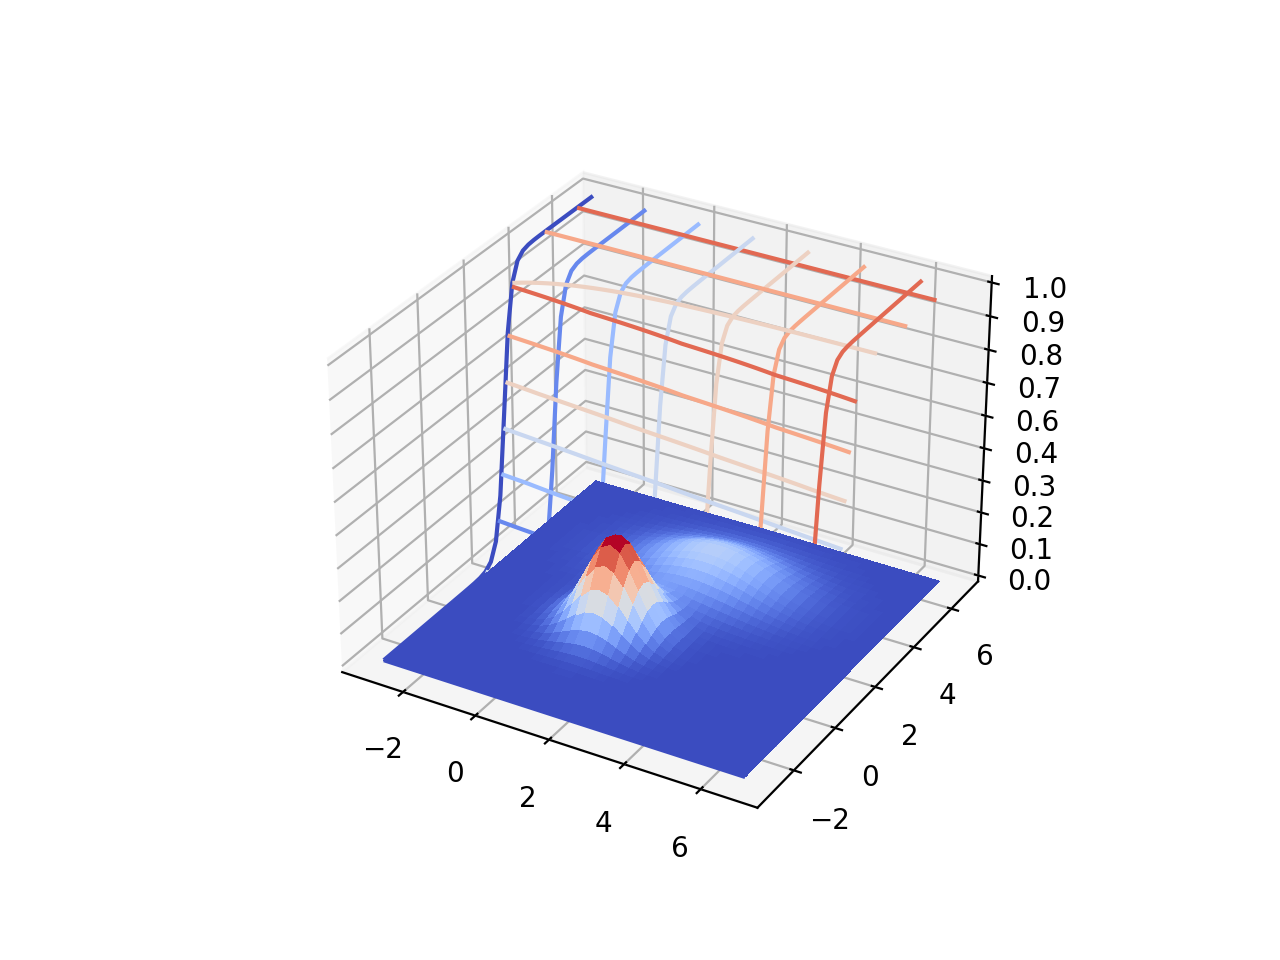

In [23]:
plot_all(mu0, sigma0, mu1, sigma1, layer)